In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta

from cosinorage.dataloaders import DataLoader
from cosinorage.features import WearableFeatures

%load_ext autoreload
%autoreload 2

In [2]:
reload_nhanes = True

In [3]:
if reload_nhanes:
    nhanes_loader = DataLoader(datasource='nhanes', input_path='../data/', person_id=62170)
    nhanes_loader.load_data(verbose=True)
    with open("nhanes_loader.pkl", "wb") as file:
        pickle.dump(nhanes_loader, file)
else:
    with open("nhanes_loader.pkl", "rb") as file:
        nhanes_loader = pickle.load(file)

Found 1 versions of NHANES data


Reading day-level files: 100%|██████████| 1/1 [00:00<00:00, 27.68it/s]


Read 9 day-level records for person 62170


Processing chunks for version G: 782it [00:57, 13.57it/s], ?it/s]
Reading minute-level files: 100%|██████████| 1/1 [00:57<00:00, 57.61s/it]


Read 11526 minute-level records for person 62170


Reading header files: 100%|██████████| 1/1 [00:00<00:00, 126.63it/s]


Merged day- and minute-level data for person 62170
Renamed columns and set timestamp index for person 62170
Calculated ENMO for person 62170
Loaded 10077 minute-level ENMO records from ../data/
Filtered out 0 minute-level ENMO records due to incomplete daily coverage
load_data executed in 57.89 seconds


In [4]:
nhanes_loader.get_enmo_data().head()

,X,Y,Z,wear,sleep,paxpredm,ENMO
TIMESTAMP,,,,,,,
1900-01-02 00:00:00,5.397605e-79,3.600000e-02,5.397605e-79,0,0,4,0.000000
1900-01-02 00:01:00,1.371000e+00,8.980000e-01,1.249000e+00,1,1,2,1.060594
1900-01-02 00:02:00,5.397605e-79,5.397605e-79,1.400000e-02,1,1,2,0.000000
1900-01-02 00:03:00,5.397605e-79,5.397605e-79,1.600000e-02,1,1,2,0.000000
1900-01-02 00:04:00,5.397605e-79,8.000000e-03,1.500000e-02,1,1,2,0.000000


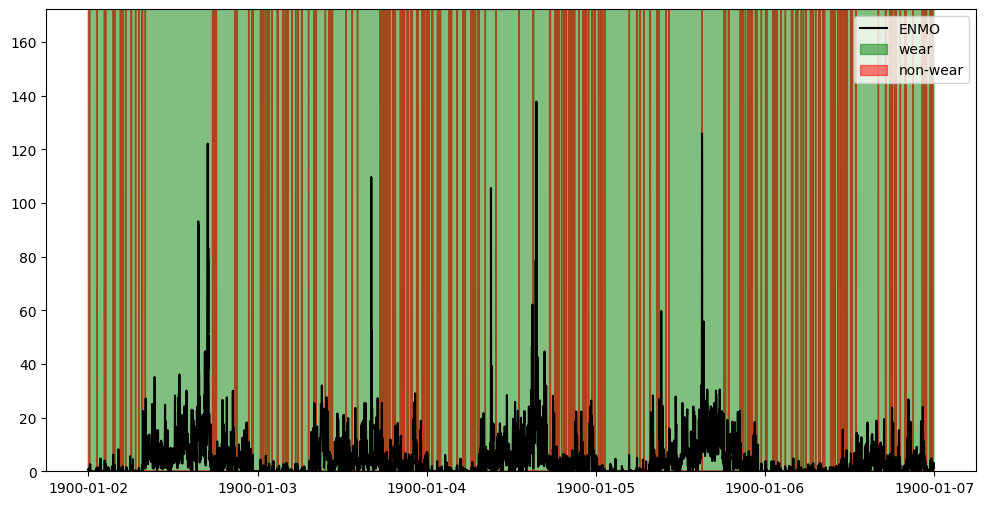

In [5]:
nhanes_loader.plot_enmo()

In [7]:
features = WearableFeatures(nhanes_loader)
features.run()
df, dict = features.get_all()


/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester03/03SemProj/CosinorAge/cosinorage/features/utils/cosinor_analysis.py:60: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  fitted_vals_df = pd.concat([fitted_vals_df, model.fittedvalues], ignore_index=False)


In [8]:
df

,MESOR,amplitude,acrophase,acrophase_time,IV,IS,RA,M10,M10_start,L5,L5_start,SB,LIPA,MVPA,TST,WASO,PTA,SRI
1900-01-02,5.513760,6.502755,-2.393140,891.532663,0.648529,0.304260,0.973200,10.664901,16,0.144851,6,8.833333,0.016667,15.150000,971,469.0,0.674306,NaN
1900-01-03,4.085448,3.670711,-2.644681,833.883681,0.470189,0.524177,0.965274,7.888524,9,0.139389,6,8.883333,0.000000,15.116667,969,446.0,0.672917,79.444444
1900-01-04,5.203611,5.785709,-2.471256,873.629857,0.548854,0.284481,0.975939,10.448192,15,0.127226,5,8.200000,0.000000,15.800000,1050,390.0,0.729167,82.083333
1900-01-05,5.017117,6.250498,-2.337716,904.235054,0.573524,0.390409,0.980114,10.053211,15,0.100964,1,9.283333,0.016667,14.700000,960,480.0,0.666667,78.055556
1900-01-06,1.648000,1.948570,-1.650424,1061.750754,0.681369,2.835111,0.944295,3.517903,15,0.100789,8,13.966667,0.033333,10.000000,671,763.0,0.465972,40.138889


In [9]:
dict

{'MESOR': np.float64(4.293587184760239),
 'amplitude': np.float64(4.700839641025021),
 'acrophase': np.float64(-2.380421652581616),
 'acrophase_time': np.float64(14.907459056367777)}

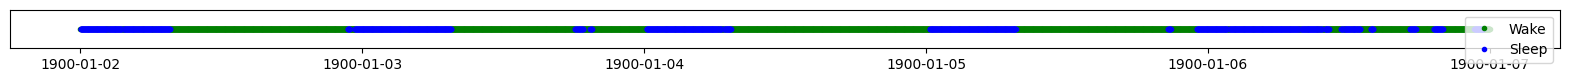

In [10]:
features.plot_sleep_predictions()

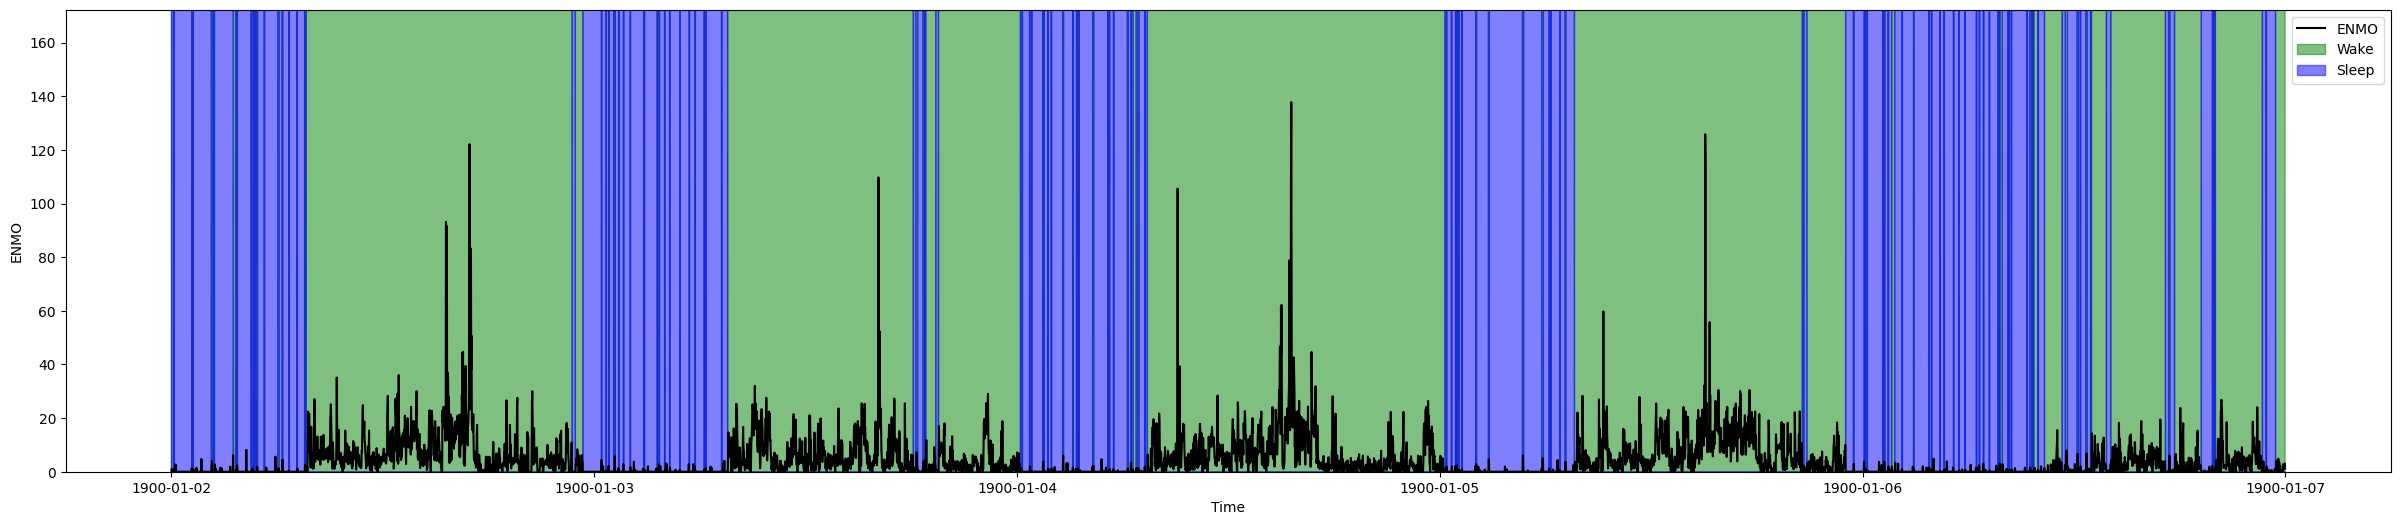

In [11]:
features.plot_sleep_predictions(simple=False)

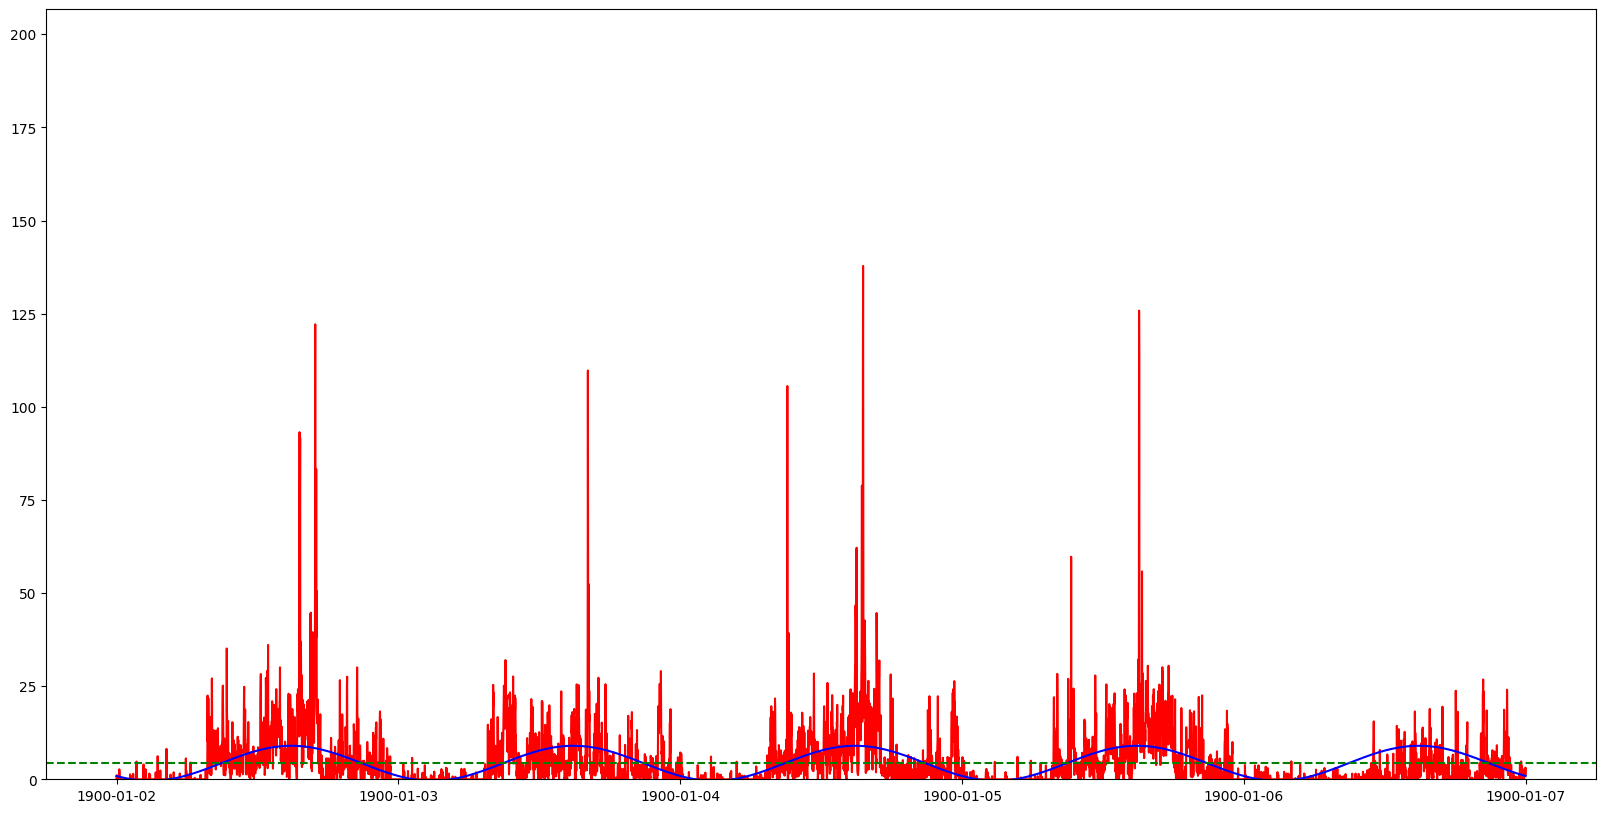

In [12]:
features.plot_cosinor()